# Predict Fish Weight Using Warped Linear Regression
*This notebook builds a warped linear regression model for predicting the weight of fish from size attributes.*

*Data is taken from [kaggle](https://www.kaggle.com/aungpyaeap/fish-market).*

In [1]:
import peak_engines
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import numpy as np
import pandas as pd
from dataset.fish.fish_dataset import X, y
np.random.seed(0)

## Prepare the dataset

In [2]:
df = pd.read_csv('Fish.csv')
df.drop(labels='Species', axis=1, inplace=True)
y = np.array(df.iloc[:,0].values, dtype=float)
X = np.array(df.iloc[:,1:].values, dtype=float)

## Fit a Warped Linear Regression Model

In [3]:
model = peak_engines.WarpedLinearRegressionModel(num_steps=1)
model.fit(X, y)
warper = model.warper
noise_stddev = np.sqrt(model.noise_variance)

## Plot the Warped Distribution

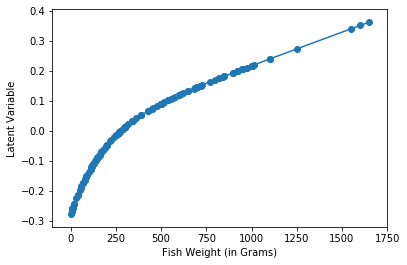

In [4]:
y_range = np.arange(np.min(y), np.max(y), 0.1)
z = warper.compute_latent(y_range)
plt.plot(y_range, z)
plt.xlabel('Fish Weight (in Grams)')
plt.ylabel('Latent Variable')
plt.scatter(y, warper.compute_latent(y))

## Define an OLS Model
OlsModel is similar to sklearn.linear_model.LinearRegression but provides methods to compute the error distribution of predictions. See [What to Do When Your Model Has a Non-Normal Error Distribution](https://medium.com/p/what-to-do-when-your-model-has-a-non-normal-error-distribution-f7c3862e475f?source=email-f55ad0a8217--writer.postDistributed&sk=f3d494b5f5a8b593f404e7af19a2fb37) for background on how the equations are derived.

In [5]:
class OlsModel:
    def __init__(self, fit_intercept = True):
        self.params_ = {
                'fit_intercept': fit_intercept
        }

    def get_params(self, deep=True):
        return self.params_

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.params_[parameter] = value

    def fit(self, X, y):
        X = self._make_feature_matrix(X)
        self.X_self_product_inv_ = np.linalg.inv(np.dot(X.T, X))
        t = np.dot(X.T, y)
        self.weights_ = np.dot(self.X_self_product_inv_, t)
        pred = np.dot(X, self.weights_)
        err = y - pred
        self.noise_variance_ = np.dot(err, err) / (X.shape[0] - X.shape[1])
        self.noise_stddev_ = np.sqrt(self.noise_variance_)

    def predict(self, X):
        X = self._make_feature_matrix(X)
        return np.dot(X, self.weights_)

    def predict_with_stddev(self, X):
        X = self._make_feature_matrix(X)
        pred = np.dot(X, self.weights_)
        stddevs = np.zeros(X.shape[0])
        for i in range(len(stddevs)):
            xi = X[i, :]
            t = np.dot(xi, np.dot(self.X_self_product_inv_, xi))
            stddevs[i] = self.noise_stddev_ * np.sqrt(1 + t)
        return pred, stddevs

    def predict_logpdf(self, X):
        pred, stddevs = self.predict_with_stddev(X)

        def logpdf(y):
            assert len(y) == X.shape[0]
            result = 0
            for i, yi in enumerate(y):
                result += norm.logpdf(yi, pred[i], stddevs[i])
            return result
        return logpdf

    def _make_feature_matrix(self, X):
        if not self.params_['fit_intercept']:
            return X
        return np.hstack((X, np.ones((X.shape[0], 1))))

## Compute Cross Validation

In [6]:
def score_log_likelihood(model, X, y):
    logpdf = model.predict_logpdf(X)
    return logpdf(y)

In [7]:
cv_splits = KFold(len(y))
wlr_scores = cross_val_score(peak_engines.WarpedLinearRegressionModel(), 
                             X, y, cv=cv_splits, 
                             scoring=score_log_likelihood)
ols_scores = cross_val_score(OlsModel(), X, y, cv=cv_splits, 
                             scoring=score_log_likelihood)
print("Ordinary Least Squares  ", np.mean(ols_scores))
print("Warped Linear Regression", np.mean(wlr_scores))

Ordinary Least Squares   -6.27854455943872
Warped Linear Regression -5.280778651513439


## Drill Down on Selected Predictions
Plot the error distributions from OLS and warped linear regression models for a few randomly selected data points.

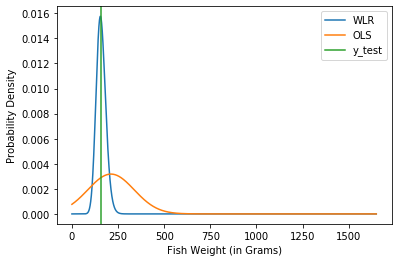

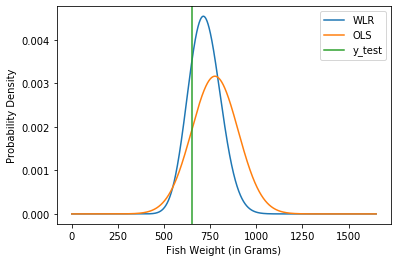

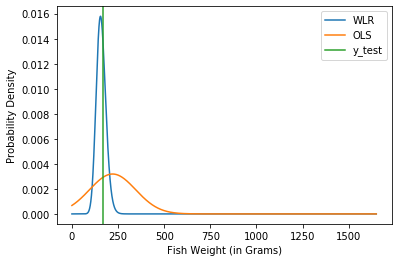

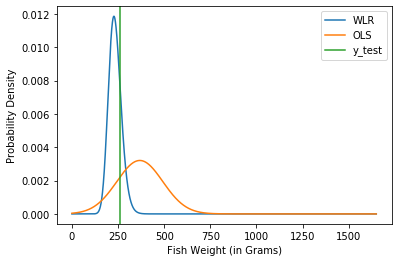

In [8]:

for index in np.random.choice(range(len(y)), size=4):
    train_indexes = [i for i in range(len(y)) if i != index]
    test_indexes = [index]
    X_train = X[train_indexes, :]
    y_train = y[train_indexes]
    X_test = X[test_indexes, :]
    y_test = y[test_indexes]
    wlr_model = peak_engines.WarpedLinearRegressionModel()
    wlr_model.fit(X_train, y_train)
    wlr_logpdf = wlr_model.predict_logpdf(X_test)
    def wlr_pdf(yi):
        return np.exp(wlr_logpdf([yi]))
    ols_model = OlsModel()
    ols_model.fit(X_train, y_train)
    ols_logpdf = ols_model.predict_logpdf(X_test)
    def ols_pdf(yi):
        return np.exp(ols_logpdf([yi]))
    plt.plot(y_range, [wlr_pdf(yi) for yi in y_range], label='WLR')
    plt.plot(y_range, [ols_pdf(yi) for yi in y_range], label='OLS')
    plt.axvline(y_test[0], label='y_test', c='tab:green')
    plt.legend()
    plt.xlabel('Fish Weight (in Grams)')
    plt.ylabel('Probability Density')
    plt.show()